In [ ]:
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    
import math
install('yfinance')
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

stock_data = yf.download('AAPL', start='2016-01-01', end='2021-10-01')
stock_data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-09-24,145.660004,147.470001,145.559998,146.919998,145.859360,53477900
2021-09-27,145.470001,145.960007,143.820007,145.369995,144.320541,74150700
2021-09-28,143.250000,144.750000,141.690002,141.910004,140.885544,108972300
2021-09-29,142.470001,144.449997,142.029999,142.830002,141.798874,74602000
2021-09-30,143.660004,144.380005,141.279999,141.500000,140.478485,89056700


Text(0, 0.5, 'Prices ($)')

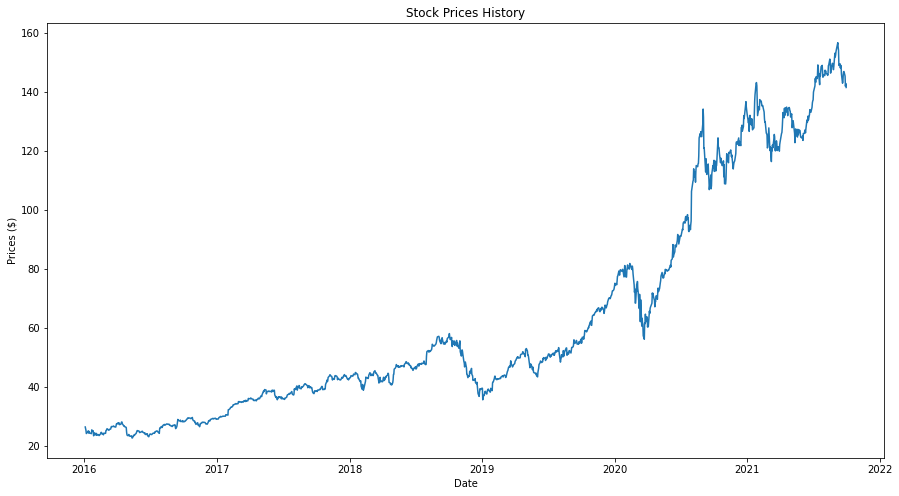

In [ ]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [ ]:
close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(10))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 10)                1010      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 122,221
Trainable params: 122,221
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=20)

Epoch 1/20
1098/1098 [==============================] - 43s 36ms/step - loss: 7.9152e-04
Epoch 2/20
1098/1098 [==============================] - 38s 34ms/step - loss: 2.8968e-04
Epoch 3/20
1098/1098 [==============================] - 38s 35ms/step - loss: 3.1681e-04
Epoch 4/20
1098/1098 [==============================] - 39s 35ms/step - loss: 1.7863e-04
Epoch 5/20
1098/1098 [==============================] - 39s 36ms/step - loss: 2.4039e-04
Epoch 6/20
1098/1098 [==============================] - 40s 37ms/step - loss: 2.1788e-04
Epoch 7/20
1098/1098 [==============================] - 39s 36ms/step - loss: 1.5755e-04
Epoch 8/20
1098/1098 [==============================] - 39s 36ms/step - loss: 2.4834e-04
Epoch 9/20
1098/1098 [==============================] - 39s 36ms/step - loss: 1.8773e-04
Epoch 10/20
1098/1098 [==============================] - 39s 36ms/step - loss: 1.7832e-04
Epoch 11/20
1098/1098 [==============================] - 41s 37ms/step - loss: 1.6218e-04
Epoch 12/20
1098/10

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

10/10 [==============================] - 2s 29ms/step


0.1354181890256677

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


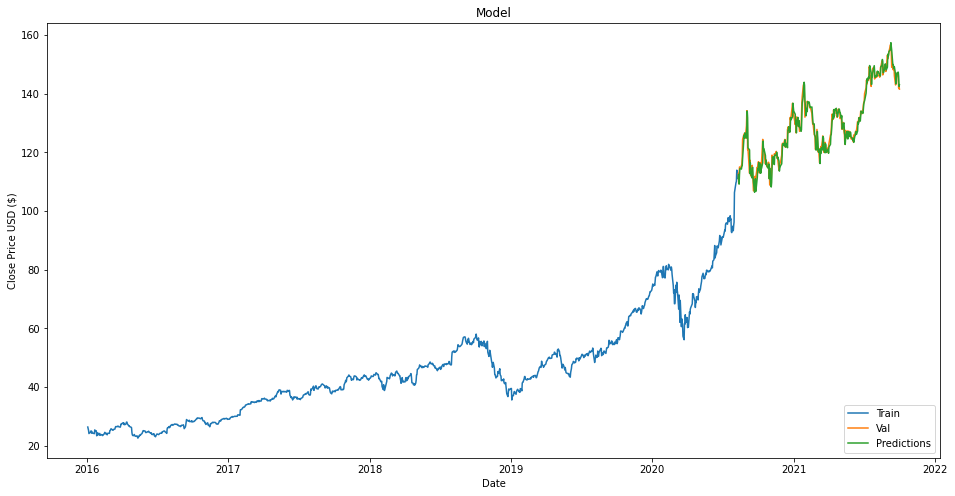

In [ ]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()